# CIFAR-10 Luokitteluprojekti (CNN)

### Business Understanding

The objective of this part of the assignment is to develop a Convolutional Neural Network (CNN) to classify images from the CIFAR-10 dataset.

The key objective is to achieve realistic classification accuracy using CNN architecture while minimizing overfitting and improving efficiency.

The aim is to compare the performance of the CNN model based on classification accuracy, learning curve, number of parameters and training time, as well as visualize the results.

### Data Understanding

**The CIFAR-10 dataset** is widely used for machine learning and computer vision research. It consists of:

- **Training Set:** 50,000 images
- **Test Set:** 10,000 images
- **Image Dimensions:** 32x32 pixels, 3 color channels (RGB)
- **Number of Classes:** 10

### Data preparation

In [1]:
from keras.src.utils import to_categorical
import keras
import numpy as np
from keras import layers
from matplotlib import pyplot as plt

In [12]:
# Load the data and split it between train and test sets
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Scale images to the [0, 1] range
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Extract label data for printing
labels = [y_test]

# One hot encode targets
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

[[3]
 [8]
 [8]
 ...
 [5]
 [1]
 [7]]


### Modeling

The basic model quickly achieved around 75% accuracy, but further improvements were challenging to attain. Adding batch normalization boosted the accuracy by a few percentage points. Testing was also conducted with deeper models and additional dense layer at the end, but these models quickly overfitted. Few models with data augmentation were also built, but the training would take very large amount of time and the models actually performed worse than the models without augmentation.

In [3]:
# Create the model
inputs = keras.Input(shape=(32, 32, 3))

x = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)
x = keras.layers.Dropout(0.5)(x)

outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="CIFAR_10_CNN")

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [4]:
model.summary()

Model: "CIFAR_10_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,274 (387.79 KB)

 Trainable params: 98,826 (386.04 KB)

 Non-trainable params: 448 (1.75 KB)

#### Callbacks
During the training of the CNN, we observed that the model began to overfit after several epochs. To combat this, we used EarlyStopping and ReduceLROnPlateau callbacks. This allowed us to prevent retraining the model from scratch each time overfitting occurred.

In [5]:
# EarlyStopping callback to stop training when validation loss stops improving
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau callback to reduce the learning rate when validation loss plateaus
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [6]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.1,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.3551 - loss: 2.1657 - val_accuracy: 0.5074 - val_loss: 1.4727 - learning_rate: 0.0010
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 42ms/step - accuracy: 0.5678 - loss: 1.2334 - val_accuracy: 0.5740 - val_loss: 1.3285 - learning_rate: 0.0010
Epoch 3/50
 978/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.6247 - loss: 1.0832


KeyboardInterrupt



### Evaluation

This code evaluates the model on the test set and prints the test loss and accuracy.

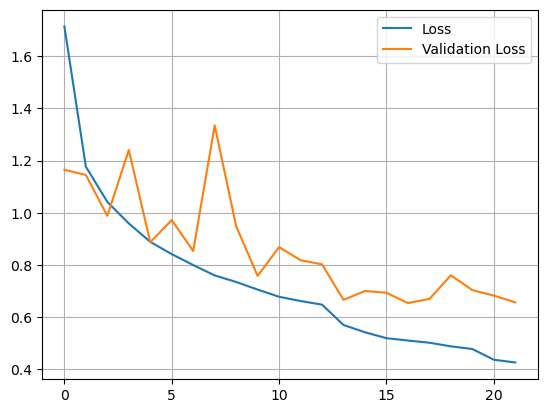

In [175]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [176]:
test_scores = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_scores[0]:.2f}")
print(f"Test accuracy: {test_scores[1]:.2f}")

Test loss: 0.68
Test accuracy: 0.77


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


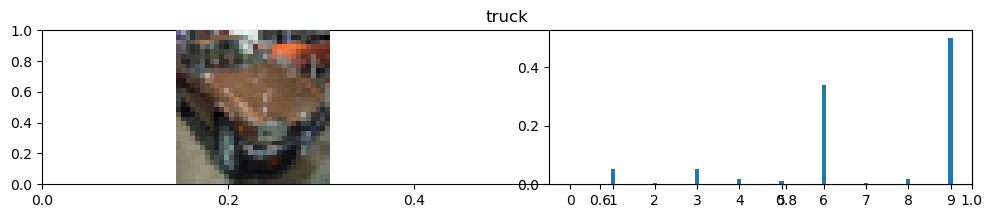

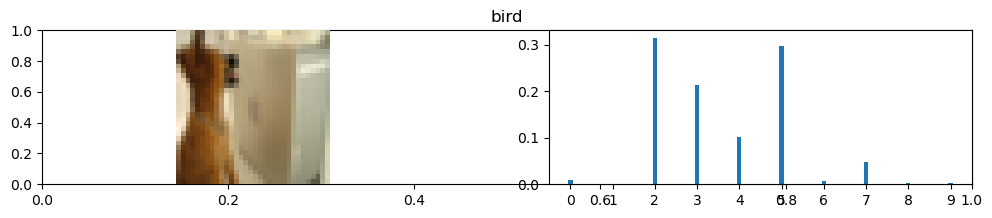

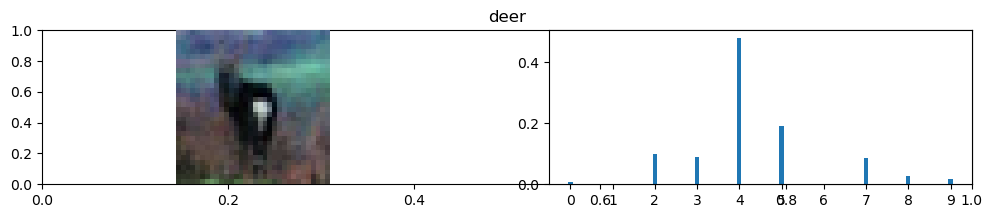

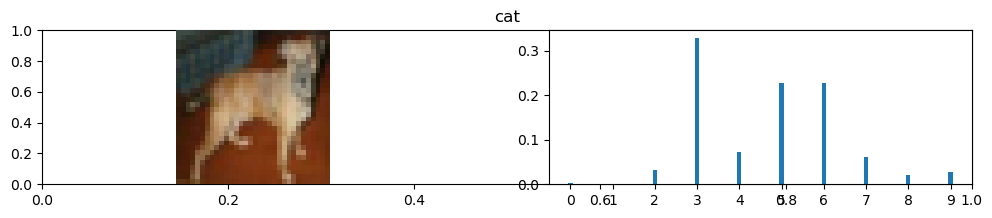

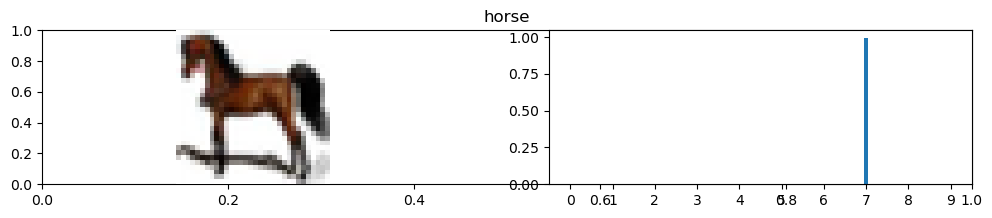

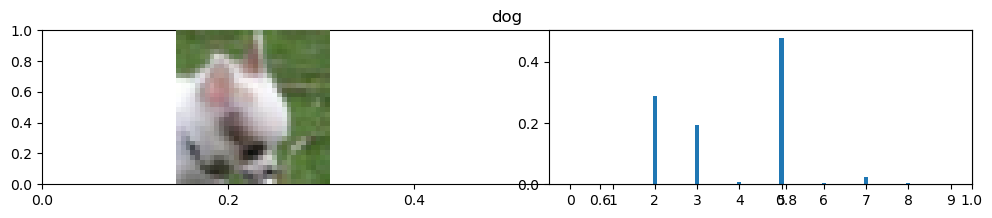

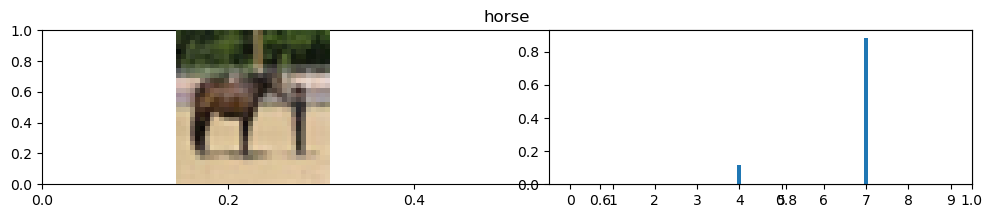

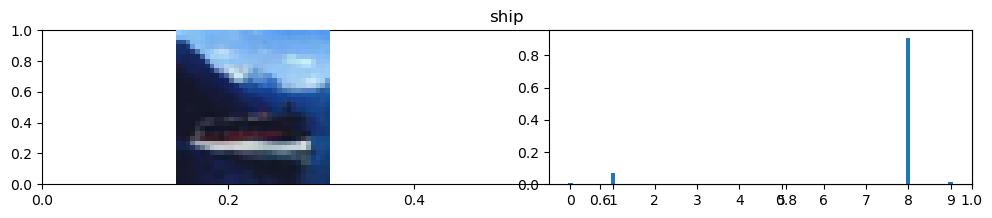

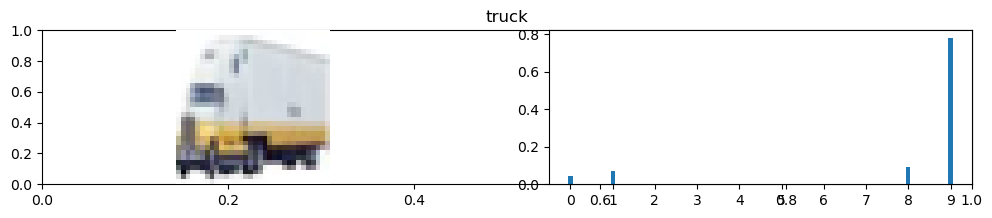

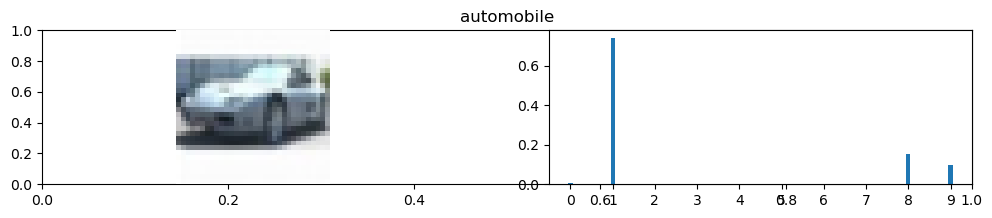

In [33]:
start = 2000

int_to_label = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

for k in range(10):
    plt.figure(figsize=(12, 2))

    # Get one image
    x = np.expand_dims(X_test[start + k], axis=0)

    # Predict
    y = model.predict(x)[0]

    # Show the image
    plt.title(int_to_label.get(np.argmax(y), "unknown"))
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[start + k])
    plt.axis("off")

    # Show the prediction probabilities
    plt.subplot(1, 2, 2)
    bar_positions = np.arange(10)
    plt.bar(np.arange(10), y, width=0.2)
    plt.xticks(range(10))

plt.show()

#### Summary

In this project, we compared the performance of an FCN model and an CNN model on the CIFAR-10 dataset. The FCN model, with 3.8 million parameters, achieved around 62% accuracy with a training time of approximately 2 hours on a CPU. In contrast, the simpler CNN model achieved around 75% accuracy with a training time of 10 minutes on a CPU.

The evaluation on the test set showed that the CNN model outperformed the FCN model in terms of both accuracy and training efficiency. Visualizations of the model's predictions helped us understand its performance and identify areas for improvement.

CNNs generally outperform FCNs because they effectively utilize spatial information in images. In FCNs, fully connected layers treat all input neurons equally, making it difficult to capture spatial features. In contrast, CNNs use convolutional layers with local receptive fields, shared weights, and pooling layers to efficiently detect patterns such as edges, textures, and shapes.

Overall, the CNN model proved to be more effective and efficient for this image classification task.